<a href="https://colab.research.google.com/github/PavelNovikov888/classification_NBC/blob/master/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%81%D0%BF%D0%B0%D0%BC%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация спама с использованием Наивного Байесовского классификатора(НБК)
В данной работе мы разберем, как искать спам-сообщения с помощью НБК реализованного в виде обычного кода Python и в виде реализации в sklearn

## Алгоритм Python.

### Библиотеки и зависимости

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

### Загрузка файлов

In [2]:
#В колабе импортируем все необходимые библиотеки
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1Y7CeR0ux08Jvc7yRCdMt0u10EJamOfUN"})
# https://drive.google.com/file/d/1Y7CeR0ux08Jvc7yRCdMt0u10EJamOfUN/view?usp=sharing
download.GetContentFile("SMSSpamCollection.zip")

Используем данные о спам-сообщениях в SMS

In [3]:
sms_data = pd.read_csv('SMSSpamCollection.zip', header=None, sep='\t', names=['Label', 'SMS'])
sms_data.head(3)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


Определим баланс классов

In [4]:
sms_data.groupby('Label').count() / sms_data.shape[0] * 100

,SMS
Label,
ham,86.593683
spam,13.406317


Данные несбалансироаваны.

### Предобработка данных

In [5]:
# использовать будем копию файла
sms_data_clean = sms_data.copy()
# заменим все небуквенные символы и space-символы на пробелы и очистим все ненужные пробелы по краям сообщений
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.replace('\W+', ' ').str.replace('\s+', ' ').str.strip()
# приведем к низкому регистру
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.lower()
# разделим строки по словам
sms_data_clean['SMS'] = sms_data_clean['SMS'].str.split()
sms_data_clean['SMS'].head(3)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
Name: SMS, dtype: object

### Разделение на обучающую и тестовую выборки

In [6]:
train_data = sms_data_clean.sample(frac=0.8,random_state=1).reset_index(drop=True)
test_data = sms_data_clean.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

Определим, сохранился ли дисбаланс классов

In [7]:
train_data['Label'].value_counts() / train_data.shape[0] * 100

ham     86.54105
spam    13.45895
Name: Label, dtype: float64

Дисбаланс сохранился

In [8]:
train_data.shape

(4458, 2)

In [9]:
test_data.shape

(1114, 2)

In [10]:
test_data.head(3)

,Label,SMS
0,ham,"[aight, should, i, just, plan, to, come, up, l..."
1,ham,"[die, i, accidentally, deleted, e, msg, i, sup..."
2,spam,"[welcome, to, uk, mobile, date, this, msg, is,..."


### Список всех слов, входящих в смс-сообщения

In [11]:
# cписок всех слов, входящих в смс-сообщения
vocabulary = list(set(train_data['SMS'].sum()))
vocabulary[11:20]

['dorothy',
 'still',
 '2gthr',
 'enc',
 'conform',
 'christmas',
 'happen',
 '32323',
 'report']

In [12]:
# размер словаря
len(vocabulary)

7783

In [13]:
for index, row in train_data[:3].iterrows():
  a = list(row[1])
  print(row[1])

['yep', 'by', 'the', 'pretty', 'sculpture']
['yes', 'princess', 'are', 'you', 'going', 'to', 'make', 'me', 'moan']
['welp', 'apparently', 'he', 'retired']


In [14]:
a.count('welp')

1

### Рассчитаем частоты слов

In [15]:
word_counts_per_sms = pd.DataFrame([
    [row[1].count(word) for word in vocabulary] for _, row in train_data.iterrows()], columns=vocabulary)

In [16]:
word_counts_per_sms.head(3)

,coupla,09061702893,department,confidence,77,09050000301,themob,9996,tool,devils,...,selected,harri,tightly,bergkamp,arguments,doke,messy,fuelled,morrow,radiator
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Получилась разреженная матрица

In [17]:
train_data = pd.concat([train_data.reset_index(), word_counts_per_sms], axis=1).iloc[:,1:]
train_data.head(3)

,Label,SMS,coupla,09061702893,department,confidence,77,09050000301,themob,9996,...,selected,harri,tightly,bergkamp,arguments,doke,messy,fuelled,morrow,radiator
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Значения для формулы Байеса

In [18]:
# коэфф. для случаев, когда слово в сообщении отсутствует в наборе данных
alpha = 1
# количество уникальных слов во всём наборе данных
Nvoc = len(train_data.columns) - 3
# случайность, что случайно взятое письмо будем спамом
Pspam = train_data['Label'].value_counts()['spam'] / train_data.shape[0]
# доля сообщений, не являющихся спамом
Pham = train_data['Label'].value_counts()['ham'] / train_data.shape[0]
# общее количество слов в спам-сообщениях
Nspam = train_data.loc[train_data['Label'] == 'spam', 'SMS'].apply(len).sum()
# общее количество слов в сообщениях, не являющихся спамом
Nham = train_data.loc[train_data['Label'] == 'ham', 'SMS'].apply(len).sum()

def p_w_spam(word):
    """ Функция вычисляет вероятность того, что слово находится в собщении, если это спам-сообщение

    Args:
       word(str): слово из сообщения

    Returns:
        float, int: уровень вероятности
    """
    if word in train_data.columns:
      # ((количество повторов слова во всех спам сообщениях) +1)/(общее количество слов в спам-сообщениях + количество уникальных слов во всем наборе данных)
        return (train_data.loc[train_data['Label'] == 'spam', word].sum() + alpha) / (Nspam + alpha*Nvoc)
    else:
        return 1


def p_w_ham(word):
    """ Функция вычисляет вероятность того, что слово находится в собщении, если это не спам-сообщение

    Args:
       word(str): слово из сообщения

    Returns:
        float, int: уровень вероятности
    """
    if word in train_data.columns:
      # ((количество повторов слова во всех не спам-сообщениях) +1)/(общее количество слов в не спам-сообщениях + количество уникальных слов во всем наборе данных)
        return (train_data.loc[train_data['Label'] == 'ham', word].sum() + alpha) / (Nham + alpha*Nvoc)
    else:
        return 1

### Реализуем алгоритм классификации

In [19]:
def classify(message):
    """ Функция производит классификацию сообщений на спам и не-спам
    Args:
        message (str): текст сообщения

    Returns:
        str: результат классификации
    """
    p_spam_given_message = Pspam
    p_ham_given_message = Pham
    # для каждого слова в сообщении
    for word in message:
      # вероятность того, что сообщение являестя спамом
      # равно вероятности получения спама в целом(доля спама в выборке умноженное
      # на произведение вероятностей того, что что в сообщении есть слово word, если письмо является спамом
        p_spam_given_message *= p_w_spam(word)
      # то же, но не к спаму
        p_ham_given_message *= p_w_ham(word)
    # если вероятность того, что письмо не спам выше чем вероятность того, что спам
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
      # если вероятность того, что письмо не спам ниже, чем вероятность того, что спам
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'классификация некорректна'

### Подведем результаты классификации

In [20]:
test_data['predicted'] = test_data['SMS'].apply(classify)
test_data.head(3)

,Label,SMS,predicted
0,ham,"[aight, should, i, just, plan, to, come, up, l...",ham
1,ham,"[die, i, accidentally, deleted, e, msg, i, sup...",ham
2,spam,"[welcome, to, uk, mobile, date, this, msg, is,...",spam


In [21]:
# выведем на экран спам-сообщения пропущенные алгоритмом
test_data.loc[test_data['predicted'] != test_data['Label']]

,Label,SMS,predicted
56,spam,"[money, i, have, won, wining, number, 946, wot...",ham
99,ham,"[gettin, rdy, to, ship, comp]",spam
142,ham,"[have, you, laid, your, airtel, line, to, rest]",spam
218,spam,"[hi, babe, its, chloe, how, r, u, i, was, smas...",ham
245,ham,[anytime],spam
404,ham,"[nokia, phone, is, lovly]",spam
491,spam,"[hi, this, is, amy, we, will, be, sending, you...",ham
588,ham,"[we, have, sent, jd, for, customer, service, c...",spam
646,ham,"[a, boy, loved, a, gal, he, propsd, bt, she, d...",классификация некорректна
912,spam,"[dating, i, have, had, two, of, these, only, s...",ham


In [22]:
# определим долю правильных ответов
correct = (test_data['predicted'] == test_data['Label']).sum() / test_data.shape[0] * 100
print(f'Доля правильных ответов алгоритма: {correct}')

Доля правильных ответов алгоритма: 99.10233393177738


## Библиотека Sklearn

### Библиотеки и зависимости

In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn import metrics #метрики
from sklearn.metrics import roc_curve
from sklearn import model_selection
from sklearn.model_selection import train_test_split #разделение выборки

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB

### Загрузка данных

In [24]:
#В колабе импортируем все необходимые библиотеки
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1MZYZV-5B2lTJR-tLcxtEg5Vs0DlXVi2_"})
# https://drive.google.com/file/d/1MZYZV-5B2lTJR-tLcxtEg5Vs0DlXVi2_/view?usp=sharing
download.GetContentFile("spam_or_not_spam.zip")

In [25]:
#откроем данные:
email_data = pd.read_csv('spam_or_not_spam.zip')
email_data.head(3)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0


In [26]:
email_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


Мы видим, что в признаке email есть нулевое значение. Чтобы это значение вошло в статистику, переведем значения в данном признаке в строку.

In [27]:
# рассчитаем частоты для классов:
freq = email_data.astype(str).groupby(by =['label'],as_index = False).count()
freq

,label,email
0,0,2500
1,1,500


In [28]:
# подготовим данные для визуализации
freq ['label'] = freq['label'].apply(lambda x: 'spam' if x=="1" else 'not_spam')
freq['email_ratio'] = round((freq['email']/freq['email'].sum()*100),1)
print(freq)

      label  email  email_ratio
0  not_spam   2500         83.3
1      spam    500         16.7


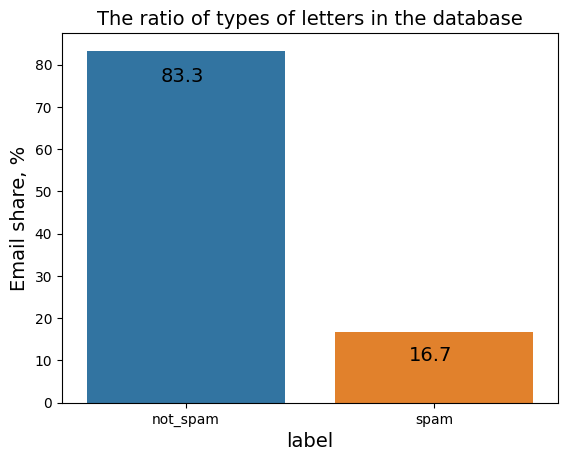

In [29]:
# визуализируем данные о соотношении типов писем
ax = sns.barplot(x=freq['label'], y=freq['email_ratio'], data = freq, ci= None);
ax.set_title("The ratio of types of letters in the database", fontsize=14)
ax.set_xlabel("label", fontsize=14)
ax.set_ylabel("Email share, %", fontsize=14)
plt.text(-0.1,76,freq.loc[0,'email_ratio'],fontsize=14)
plt.text(0.9,10,freq.loc[1,'email_ratio'],fontsize=14);

Количество типов писем несбалансированно, требуется стратификация во время разделения выборки.

### Предобработка данных

Предобработаем  данные и переведём их в векторный вид.
Заменим в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалим из данных все строки, в которых наблюдаются пропущенные значения.

In [30]:
email_data_clean = email_data.copy()
email_data_clean['email'] = email_data_clean['email'].replace(r'^\s*$', np.nan, regex = True).replace('', np.nan)

email_data_clean = email_data_clean.dropna()
email_data_clean.isnull().sum()

email    0
label    0
dtype: int64

Результат: Строки с пропущенными значениями удалены.

СountVectorizer — это алгоритм для векторизации текста, т.е. превращения текста в вектор из чисел. Алгоритм находит все слова, встречающиеся во всех текстах датасета (строках таблицы), и использует их как признаки (столбцы). В результате преобразования вы получите матрицу размера n*m , где  n — количество строк в таблице (количество текстов), а m — количество всех слов в датасете.
CountVectorizer возвращает csr_matrix  


In [31]:
# Переведем данные в векторный вид:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(email_data_clean["email"])
X_array = X.toarray()
X_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [32]:
X

<2997x34116 sparse matrix of type '<class 'numpy.int64'>'
	with 348376 stored elements in Compressed Sparse Row format>

In [33]:
# Определим, сколько теперь признаков в нашем наборе данных:
X.shape

(2997, 34116)

### Разделение на обучающую и тестовую выборки

In [34]:
# Определим целевую переменную и признаки:
y = email_data_clean['label'].astype(int)

In [35]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_array, y, stratify = y, test_size=0.25, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2247, 34116)
Test shape: (750, 34116)


In [36]:
# определим,сохранилось ли соотношение классов в выборках
print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.834001
1    0.165999
Name: label, dtype: float64


Test : 0    0.834667
1    0.165333
Name: label, dtype: float64


Результат: Классы сбалансированны.

### Используем алгоритм ComplementNB на основе НБК

In [37]:
# Используем для обучения алгоритм ComplementNB, т.к. этот алгоритм показывает высокое качество в задачах классификации текстов.
clf = ComplementNB(alpha=0.01)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [38]:
#Рассчитываем accuracy
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))
#Рассчитываем precision
print('Precision: {:.3f}'.format(metrics.precision_score(y_test, y_pred)))
#Рассчитываем recall
print('Recall: {:.3f}'.format(metrics.recall_score(y_test, y_pred)))
#Рассчитываем F1-меру
print('F1 score: {:.3f}'.format(metrics.f1_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.988
Precision: 1.000
Recall: 0.927
F1 score: 0.962
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       626
           1       1.00      0.93      0.96       124

    accuracy                           0.99       750
   macro avg       0.99      0.96      0.98       750
weighted avg       0.99      0.99      0.99       750



Действительно, алгоритм ComplementNB показывает высокое качество предсказаний, т.к. метрики на тестовой выборке близки к 1.00.
Тем не менее, сравним качество предсказаний с другим алгоритмом, работающим с текстами и несбалансированными выборками: MultinomialNB

### Используем алгоритм MultinomialNB на основе НБК

In [39]:
# Применим алгоритм MultinomialNB
mlt = MultinomialNB(alpha=0.01)
mlt.fit(X_train, y_train)
y_pred_mlt = mlt.predict(X_test)

### Сравним результаты работы алгоритмов с помощью ROC-кривой

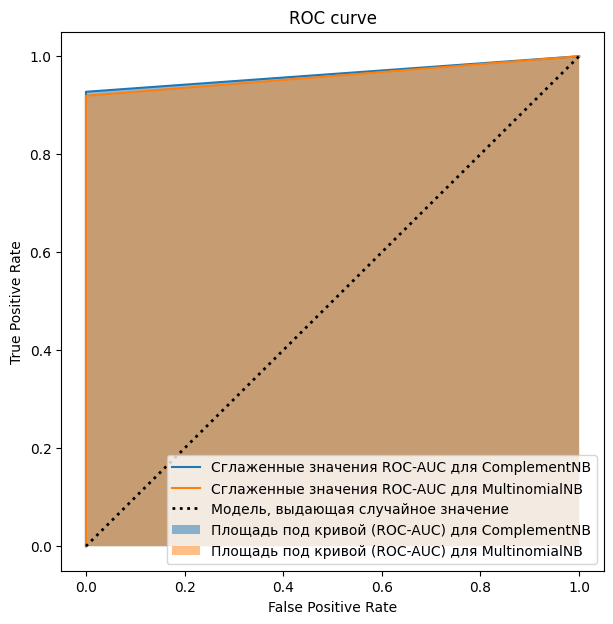

In [40]:
# Нарисуем ROC-кривую:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, y_pred)
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates,
         label='Сглаженные значения ROC-AUC для ComplementNB')

# Нарисуем ROC-кривую:
false_positive_rates_mlt, true_positive_rates_mlt, threshold_mlt = roc_curve(y_test, y_pred_mlt)

# рисуем кривую
plt.plot(false_positive_rates_mlt, true_positive_rates_mlt,
         label='Сглаженные значения ROC-AUC для MultinomialNB')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':',
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates,
                 alpha=0.5, label='Площадь под кривой (ROC-AUC) для ComplementNB')

plt.fill_between(false_positive_rates_mlt, true_positive_rates_mlt,
                 alpha=0.5, label='Площадь под кривой (ROC-AUC) для MultinomialNB')

plt.legend()
plt.show()

In [41]:
auc = metrics. roc_auc_score (y_test, y_pred)
print(f"Площадь под кривой (ROC-AUC для ComplementNB): {round(auc,5)}")
auc_mlt = metrics. roc_auc_score (y_test, y_pred_mlt)
print(f"Площадь под кривой (ROC-AUC для MultinomialNB): {round(auc_mlt,5)}")

Площадь под кривой (ROC-AUC для ComplementNB): 0.96371
Площадь под кривой (ROC-AUC для MultinomialNB): 0.95968


Вывод: Изначальный выбор алгоритма классификации текста ComplementNB был верным, т.к. показатели точности прогнозирования, судя по площади под графиком ROC-AUC выше.
Однако это превышение небольшое, и показатели площадей под графиком ROC-AUC близки к единице, поэтому оба использованных алгоритма могут быть достаточно эффективными для решения поставленной задачи.

### Подбор гиперпараметров. Кросс-валидация.

Переберём несколько значений alpha с помощью кросс-валидации для оценки, зависит ли от этого параметра качество классификации.
Для оценки будем использовать метрику F1-score, т.к. она дает обобщенное представление об метриках точности (Precision) и полноты(Recall).

In [42]:

#Создаем объект класса
alpha_var = [0.01,0.1,0.5,1]
for num in alpha_var:
    model = ComplementNB(
    alpha = num)
#Создаём объект кросс-валидатора KFold
    kf = model_selection.StratifiedKFold(n_splits=5)

#Считаем метрики на кросс-валидации k-fold
    cv_metrics = model_selection.cross_validate(
        estimator=model, #модель
        X=X_train, #матрица наблюдений X
        y=y_train, #вектор ответов y
        cv=kf, #кросс-валидатор
        scoring='f1', #метрика
        return_train_score=True #подсчёт метрики на тренировочных фолдах
    )
    print(f"Коэффицент сглаживания alpha: {num}")
    print(f"Динамика значения метрики f1 на тестовом наборе данных {cv_metrics['test_score']} в зависимости от размера обучающей выборки")


Коэффицент сглаживания alpha: 0.01
Динамика значения метрики f1 на тестовом наборе данных [0.95172414 0.97986577 0.96551724 0.97260274 0.96551724] в зависимости от размера обучающей выборки
Коэффицент сглаживания alpha: 0.1
Динамика значения метрики f1 на тестовом наборе данных [0.95302013 0.98666667 0.96644295 0.96598639 0.97959184] в зависимости от размера обучающей выборки
Коэффицент сглаживания alpha: 0.5
Динамика значения метрики f1 на тестовом наборе данных [0.96       0.98013245 0.96644295 0.97959184 0.97297297] в зависимости от размера обучающей выборки
Коэффицент сглаживания alpha: 1
Динамика значения метрики f1 на тестовом наборе данных [0.95238095 0.98013245 0.96598639 0.97931034 0.97260274] в зависимости от размера обучающей выборки


Максимальное значение метрики f1 на тестовом наборе данных 0.97959184 соответствует коэффиценту сглаживания alpha: 0.1, однако это не говорит о том, что это в принципе наилучший уровень, ведь значения коэффицента сглаживания выбраны мною произвольно.
Так же не наблюдается линейной зависимости между качеством предсказания и коэффицентом сглаживания. При увеличении этого коэффицента вначале наблюдается рост значения метрики, затем спад.
Чтобы увидеть эти эффекты воочию, построим кривые обучения.

In [43]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    """Функция строит кривые обучения

    Args:
        model (object type that implements the “fit” and “predict” methods): Используемая модель машинного обучения
        X (array-like of shape): матрица наблюдений X
        y (array-like of shape): вектор ответов y
        cv (int, cross-validation generator or an iterable): кросс-валидатор, default=None
        scoring_type_, optional (str or callable): метрика для оценки модели, default=None
        ax (AxesSubplot):координатная плоскость Defaults to None.
        title (str):Название графика
    """

    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring="f1",  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0.5, 1)
    # Отображаем легенду
    ax.legend()

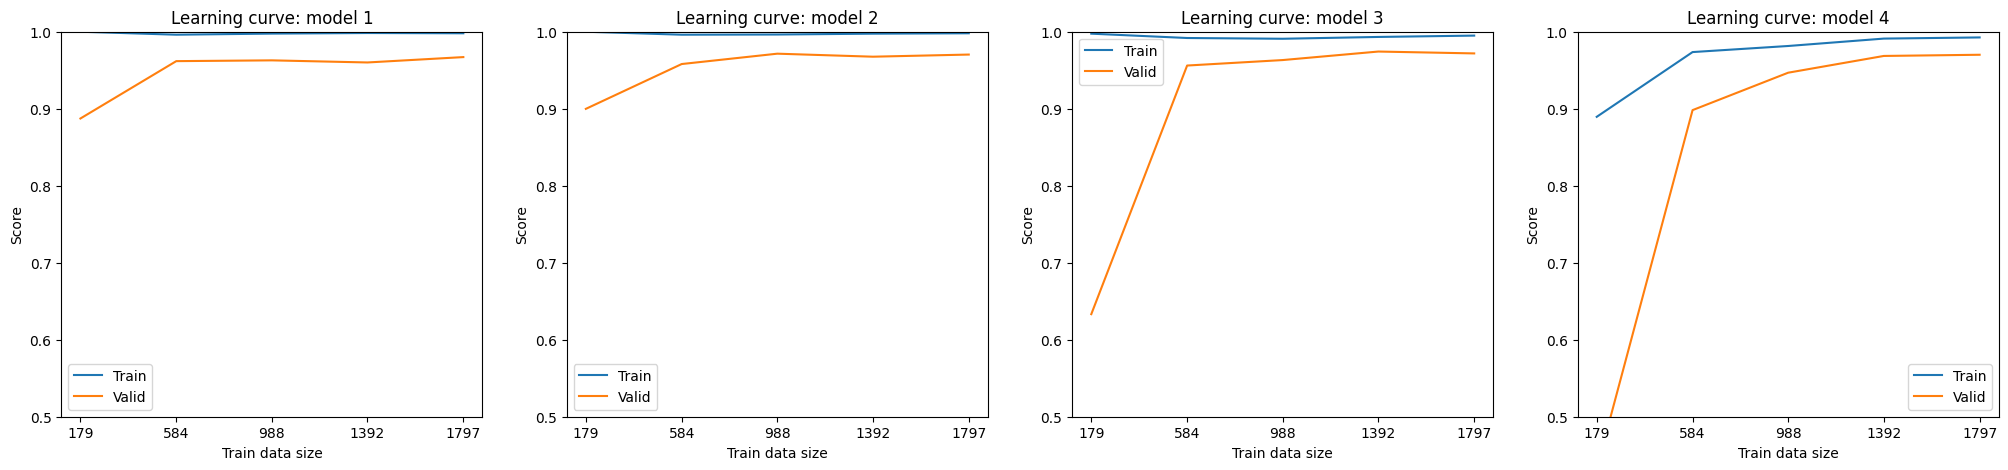

In [44]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
# Создаем список моделей с различными значениями коэффицента сглаживания alpha
models = [ComplementNB (alpha = 0.01), ComplementNB (alpha = 0.1), ComplementNB (alpha = 0.5), ComplementNB (alpha = 1)]
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 4, figsize=(25, 5)) #фигура + четыре координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X_train, y_train, skf, ax=axes[i], title=f'model {i+1}')

Выводы: Переобучения модели не наблюдается, расстояние между кривыми сравнительно небольшое и самое главное, тренировочная и валидационная кривые сходятся друг к другу и достигают приемлемого качества.
В целом, существенной разницы в качестве классификации модели между различными значениями коэффицента alpha не наблюдается, разница видна только от количества наблюдений в тренировочной базе данных.

### Подбор гиперпараметров. Optuna.

In [45]:
%pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [46]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.4.0


In [47]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  alpha = trial.suggest_float('alpha', 0.01, 1,step=0.01,log=False)

  # создаем модель
  model = sklearn.naive_bayes.MultinomialNB(alpha = alpha)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test))

  return score

In [48]:
%%time
# cоздаем объект исследования

# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="MultinomialN", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2023-11-14 13:38:06,859] A new study created in memory with name: MultinomialN
[I 2023-11-14 13:38:07,572] Trial 0 finished with value: 0.979591836734694 and parameters: {'alpha': 0.12}. Best is trial 0 with value: 0.979591836734694.
[I 2023-11-14 13:38:08,292] Trial 1 finished with value: 0.979591836734694 and parameters: {'alpha': 0.25}. Best is trial 0 with value: 0.979591836734694.
[I 2023-11-14 13:38:09,173] Trial 2 finished with value: 0.9669421487603306 and parameters: {'alpha': 0.99}. Best is trial 0 with value: 0.979591836734694.
[I 2023-11-14 13:38:10,041] Trial 3 finished with value: 0.979591836734694 and parameters: {'alpha': 0.6}. Best is trial 0 with value: 0.979591836734694.
[I 2023-11-14 13:38:11,264] Trial 4 finished with value: 0.979591836734694 and parameters: {'alpha': 0.8}. Best is trial 0 with value: 0.979591836734694.
[I 2023-11-14 13:38:12,139] Trial 5 finished with value: 0.979591836734694 and parameters: {'alpha': 0.81}. Best is trial 0 with value: 0.979591

CPU times: user 7.34 s, sys: 1.03 s, total: 8.37 s
Wall time: 8.81 s


In [49]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

По результатам оптимизации подтверждается вывод, что с повышением alpha качество предсказания вначале растет, затем рост прекращается и становится максимальным при максимальном значении alpha